In [36]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from tiny_ta import atr, rsi, sma

# End of the Month - Strategie im S&P 500

Zunächst werden die Kursdaten für den S&P 500 geladen und bereinigt

In [37]:
SYMBOL = "^GSPC"
SYMBOL = "SPY"

stock = yf.download(SYMBOL)

stock = stock[~(stock.High == stock.Low) & ~(stock.Open == stock.Close)]
stock = stock.dropna()

[*********************100%%**********************]  1 of 1 completed


Der VIX für die Volatilität wird als externer Indikator mit betrachtet

In [38]:
vix = yf.download("^VIX")
vix["vix"] = vix["Close"]
stock = pd.merge(
    stock,
    vix[
        [
            "vix",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Die 5 jährigen Staatsanleihen werden ebenfalls mit betrachtet

In [39]:
yield_5_years = yf.download("^FVX")

yield_5_years["yield_5yr"] = yield_5_years["Close"]
stock = pd.merge(
    stock,
    yield_5_years[
        [
            "yield_5yr",
        ]
    ],
    left_index=True,
    right_index=True,
    how="left",
)

[*********************100%%**********************]  1 of 1 completed


Ein paar Indikatoren für spätere Auswertungen

In [40]:
stock["rsi_3"] = rsi(stock.Close, 3)
stock["rsi_7"] = rsi(stock.Close, 7)
stock["rsi_10"] = rsi(stock.Close, 10)

stock["atr_10"] = atr(stock, 10, smoothing="rma") / stock.Close * 100

adx_intervall = 21
adx = ta.adx(stock.High, stock.Low, stock.Close, adx_intervall)
stock["adx"] = adx[f"ADX_{adx_intervall}"]
stock["adx_direction"] = np.where(
    adx[f"DMP_{adx_intervall}"] > adx[f"DMN_{adx_intervall}"], 1, -1
)

stock["adx_10"] = ta.adx(stock.High, stock.Low, stock.Close, 10, 10)["ADX_10"]


stock["sma"] = sma(stock.Close, 20)
stock["sma_20"] = stock.Close / sma(stock.Close, 20)
stock["sma_50"] = stock.Close / sma(stock.Close, 50)
stock["sma_100"] = stock.Close / sma(stock.Close, 100)
stock["sma_200"] = stock.Close / sma(stock.Close, 200)

stock["sma_pct"] = (stock.Close / stock.sma).round(2)

stock["month"] = stock.index.month

Markiere die letzten x Tage und ersten x Tage im Monat für die geplanten Trades. 

In [41]:
days = 5

# Identify end of month
end_of_month = stock.groupby([stock.index.year, stock.index.month]).tail(days)

# Identify beginning of month
beginning_of_month = stock.groupby([stock.index.year, stock.index.month]).head(days)

# add countdown
end_of_month["countdown"] = -1
end_of_month["days"] = end_of_month["countdown"].cumsum().add(1).mod(days)
end_of_month.loc[end_of_month.days == days, "days"] = 0
end_of_month["days"] = (end_of_month["days"].add(1)) * -1

beginning_of_month["countdown"] = 1
beginning_of_month["days"] = beginning_of_month["countdown"].cumsum().sub(1).mod(days)
beginning_of_month.loc[beginning_of_month.days == 0, "days"] = days

# Combine the results
marked_days = pd.concat([end_of_month, beginning_of_month])
marked_days["hold"] = 1

df = pd.merge(
    left=stock,
    right=marked_days[["hold", "days"]],
    left_index=True,
    right_index=True,
    how="left",
)

df.hold = df.hold.fillna(0)

df["buy"] = np.where(
    (df.hold.shift(1) == 0) & (df.hold == 1),
    1,
    np.where((df.hold == 1) & (df.hold.shift(-1) == 0), -1, np.nan),
)

df.hold = np.where(df.hold == 1, df.Low, np.nan)

## Jetzt zur Strategie
Es wird 5 Tage vor Monatsende gekauft und 5 Tage nach Monatsanfang gekauft

In [42]:
from backtesting import Strategy


class end_of_month(Strategy):
    """
    strategy for trend_trading
    """

    days_before = -5
    days_after = 5

    def ohlc(self, pos=-1) -> tuple:
        """
        helper function for ohlc data
        """
        return (
            self.data.Open[pos],
            self.data.High[pos],
            self.data.Low[pos],
            self.data.Close[pos],
        )

    def init(self):
        super().init()

        self.sma = self.I(lambda: self.data.sma, name="SMA")

        # self.rsi = self.I(lambda: self.data.rsi, name="RSI", overlay=False)
        self.atr_10 = self.I(lambda: self.data.atr_10, name="ATR", overlay=False)

        self.vix = self.I(lambda: self.data.vix, name="VIX", overlay=False)
        self.yield_5yr = self.I(
            lambda: self.data.yield_5yr, name="Yield 5", overlay=False
        )

    def next(self):
        # super().next()

        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if self.data.days[-1] == self.days_before:
            self.buy()

In [43]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":], end_of_month, cash=100_000, commission=0.002, trade_on_close=True
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   47.966157
Equity Final [$]                 240683.73813
Equity Peak [$]                 248033.545824
Return [%]                         140.683738
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                    7.468298
Volatility (Ann.) [%]               11.545455
Sharpe Ratio                          0.64686
Sortino Ratio                        1.035581
Calmar Ratio                         0.627864
Max. Drawdown [%]                  -11.894769
Avg. Drawdown [%]                   -1.746064
Max. Drawdown Duration      888 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                  148
Win Rate [%]                        61.486486
Best Trade [%]                       9.352854
Worst Trade [%]                     -7.925611
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

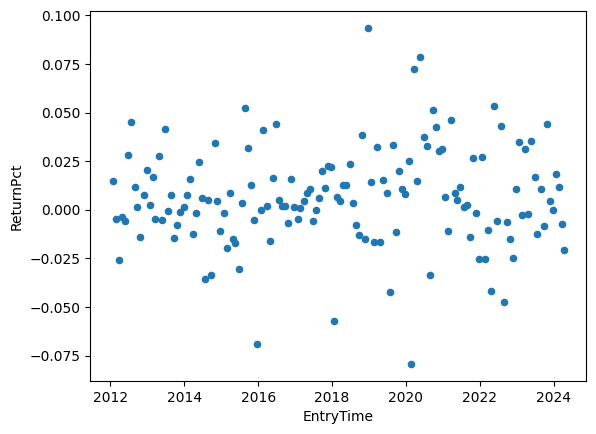

In [44]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

In [45]:
trades[trades.ReturnPct < -0.05]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
47,566,994,1003,206.091353,191.919998,-8020.986643,-0.068762,2015-12-24,2016-01-08,15 days
72,467,1513,1522,283.866588,267.670013,-7563.800217,-0.057057,2018-01-25,2018-02-07,13 days
97,487,2031,2040,323.064853,297.459991,-12469.567794,-0.079256,2020-02-24,2020-03-06,11 days


Vielleicht wäre ein Stopp doch hilfreich

In [46]:
class end_of_month_with_SL(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if trade.pl_pct < -0.06:
                    trade.close()

                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [47]:
from backtesting import Backtest

bt = Backtest(
    df["2012-01-01":],
    end_of_month_with_SL,
    cash=100_000,
    commission=0.002,
    trade_on_close=True,
)
stats = bt.run()
bt.plot(superimpose=False, open_browser=False)
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                     47.6082
Equity Final [$]                232502.623975
Equity Peak [$]                 239589.982047
Return [%]                         132.502624
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                     7.16396
Volatility (Ann.) [%]               11.234276
Sharpe Ratio                         0.637688
Sortino Ratio                        1.011577
Calmar Ratio                         0.523896
Max. Drawdown [%]                    -13.6744
Avg. Drawdown [%]                   -1.807317
Max. Drawdown Duration      888 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                  148
Win Rate [%]                        61.486486
Best Trade [%]                       9.352854
Worst Trade [%]                     -7.910128
Avg. Trade [%]                    

<Axes: xlabel='EntryTime', ylabel='ReturnPct'>

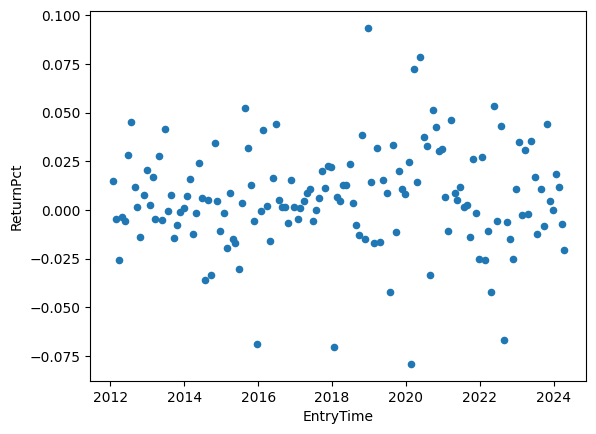

In [48]:
trades = stats["_trades"]
trades.plot.scatter(y="ReturnPct", x="EntryTime")

jetzt wird überprüft welche Tage für die Ein- und Ausstiege besser sein könnten.

In [49]:
stats, heatmap = bt.optimize(
    days_before=range(-5, 0, 1),
    days_after=range(1, 6),
    maximize="Profit Factor",  # "Equity Final [$]",
    max_tries=200,
    random_state=0,
    return_heatmap=True,
)

/Users/produktmanagement/Python/github/backtesting-trading-strategies/.venv/lib/python3.12/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [50]:
# heatmap
heatmap.sort_values().iloc[-3:]

days_before  days_after
-5           4             1.738741
-4           5             1.790877
-5           5             1.914479
Name: Profit Factor, dtype: float64

In [51]:
heatmap.groupby(["days_before", "days_after"]).mean().unstack()

days_after,1,2,3,4,5
days_before,,,,,
-5,1.460246,1.585968,1.521880,1.738741,1.914479
-4,1.317272,1.415477,1.433416,1.630773,1.790877
-3,1.217611,1.312510,1.340430,1.507865,1.655319
-2,0.862656,0.962562,1.048203,1.154826,1.324867
-1,0.994289,1.144525,1.193081,1.410071,1.591270


In [52]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                     47.6082
Equity Final [$]                232502.623975
Equity Peak [$]                 239589.982047
Return [%]                         132.502624
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                     7.16396
Volatility (Ann.) [%]               11.234276
Sharpe Ratio                         0.637688
Sortino Ratio                        1.011577
Calmar Ratio                         0.523896
Max. Drawdown [%]                    -13.6744
Avg. Drawdown [%]                   -1.807317
Max. Drawdown Duration      888 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                  148
Win Rate [%]                        61.486486
Best Trade [%]                       9.352854
Worst Trade [%]                     -7.910128
Avg. Trade [%]                    

The Winner is ...

In [53]:
stats["_strategy"]

<Strategy end_of_month_with_SL(days_before=-5,days_after=5)>

In [54]:
# bt = Backtest(df["2012-01-01":], end_of_month, cash=100_000, commission=0.002)
stats = bt.run(days_before=-4, days_after=5)
bt.plot(superimpose=False, open_browser=False)

Row(id='10883', ...)

In [55]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                    43.01985
Equity Final [$]                200057.212829
Equity Peak [$]                 207715.040118
Return [%]                         100.057213
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                    5.851256
Volatility (Ann.) [%]               10.544373
Sharpe Ratio                         0.554917
Sortino Ratio                        0.858418
Calmar Ratio                          0.45168
Max. Drawdown [%]                  -12.954437
Avg. Drawdown [%]                   -2.098897
Max. Drawdown Duration     1219 days 00:00:00
Avg. Drawdown Duration       53 days 00:00:00
# Trades                                  148
Win Rate [%]                        58.783784
Best Trade [%]                       6.560989
Worst Trade [%]                     -8.087376
Avg. Trade [%]                    

Die Win Rate beim Trading bezieht sich auf das Verhältnis der Anzahl der gewonnenen Trades zur Gesamtanzahl der Trades. 
Wenn jemand beispielsweise 70% seiner Trades gewinnt, beträgt seine Win Rate 70%.

In [56]:
stats["Win Rate [%]"]

58.78378378378378

Durchschnittlicher Gewinn in Prozent. 
Wie viel Gewinn oder Verlust wurden im Durchschnitt pro Trade erzielt.

In [57]:
stats["Avg. Trade [%]"]

0.46987206521527103

Der Profit-Faktor stellt die Verhältnisse zwischen Gewinnen und Verlusten dar.
Der Profit-Faktor wird berechnet, indem die Summe aller Profite (Gewinne) durch die Summe aller Verluste (einschließlich Gebühren und Kommissionen) für den gesamten Handelszeitraum geteilt wird.
Ein Profit-Faktor größer als 1 zeigt an, dass die Strategie profitabel ist. Je höher der Wert, desto besser.

Ein guter Profit-Faktor liegt normalerweise zwischen 1,75 und 41.
Ein Wert über 1,75 zeigt eine solide Strategie an, während Werte über 4 außergewöhnlich gut sind.

In [58]:
stats["Profit Factor"]

1.7908772515213376

In [59]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)
# merged["win"] = np.where(merged.PnL > 0, 1, -1)

In [60]:
# merged.set_index('EntryTime')
monthly = pd.DataFrame(merged.groupby(merged.EntryTime.dt.month).ReturnPct.sum())
# global skip_month
skip_month = monthly[monthly["ReturnPct"] < 0.05].index.to_list()
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
1,0.0143
2,0.0570
3,-0.0315
4,0.0091
5,-0.0081
6,0.1969
7,0.1736
8,0.0190
9,0.0446


<Axes: title={'center': 'Gewinner Trades'}>

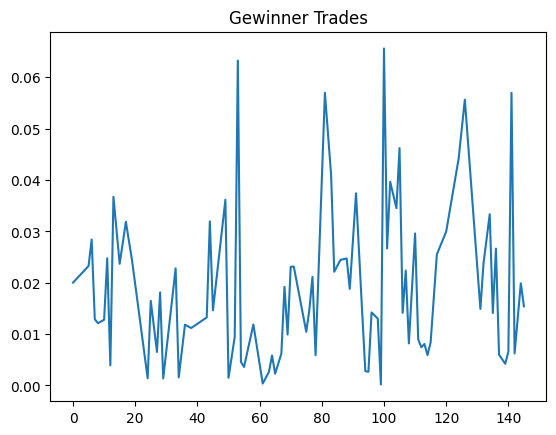

In [61]:
merged[merged.PnL > 0].ReturnPct.plot(title="Gewinner Trades")

<Axes: title={'center': 'Verlierer Trades'}>

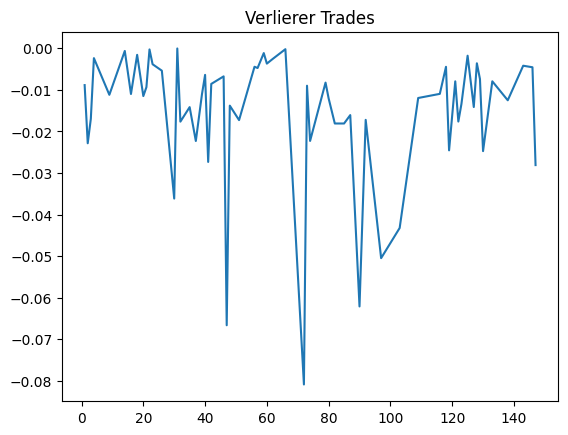

In [62]:
merged[merged.PnL < 0].ReturnPct.plot(title="Verlierer Trades")

In [63]:
class end_of_month_and_skip_month(end_of_month):
    """
    strategy for trend_trading
    """

    skip_month = []

    def next(self):
        _open, _high, _low, _close = self.ohlc()

        # trade management for an existing trade
        for trade in self.trades:
            if trade.is_long:
                if self.data.days[-1] == self.days_after:
                    trade.close()

        if (
            self.data.days[-1] == self.days_before
            and self.data.month[-1] not in self.skip_month
        ):
            self.buy()

In [64]:
df

,Open,High,Low,Close,Adj Close,Volume,vix,yield_5yr,rsi_3,rsi_7,...,sma,sma_20,sma_50,sma_100,sma_200,sma_pct,month,hold,days,buy
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763733,1003200,12.420000,5.570,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,43.750000,-1.0,NaN
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.763733,1003200,12.420000,5.570,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,43.750000,5.0,NaN
1993-02-01,43.968750,44.250000,43.968750,44.250000,24.939873,480500,12.330000,5.550,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,43.968750,1.0,NaN
1993-02-02,44.218750,44.375000,44.125000,44.343750,24.992702,201300,12.250000,5.630,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,44.125000,2.0,NaN
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.256893,529400,12.120000,5.620,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,44.375000,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-10,513.479980,516.159973,512.090027,514.119995,514.119995,82652800,15.800000,4.615,25.0,39.0,...,518.10,0.992318,1.010774,1.052425,1.108208,0.99,4,512.090027,-5.0,1.0
2024-04-11,515.679993,519.479980,512.080017,518.000000,518.000000,70099000,14.910000,4.623,54.0,51.0,...,518.21,0.999595,1.017322,1.058872,1.115538,1.00,4,512.080017,-4.0,NaN
2024-04-12,514.369995,515.820007,509.079987,510.850006,510.850006,92469100,17.309999,4.533,26.0,36.0,...,518.00,0.986197,1.002178,1.042977,1.099264,0.99,4,509.079987,-3.0,NaN


In [65]:
bt = Backtest(
    df["2012-01-01":], end_of_month_and_skip_month, cash=100_000, commission=0.002
)
stats = bt.run(days_before=-4, days_after=5, skip_month=skip_month)
bt.plot(superimpose=False)  # , open_browser=False)

Row(id='12430', ...)

In [66]:
stats

Start                     2012-01-03 00:00:00
End                       2024-04-16 00:00:00
Duration                   4487 days 00:00:00
Exposure Time [%]                   14.350797
Equity Final [$]                179826.990962
Equity Peak [$]                 179826.990962
Return [%]                          79.826991
Buy & Hold Return [%]              294.925489
Return (Ann.) [%]                      4.9299
Volatility (Ann.) [%]                5.789707
Sharpe Ratio                         0.851494
Sortino Ratio                        1.370868
Calmar Ratio                         0.594938
Max. Drawdown [%]                   -8.286407
Avg. Drawdown [%]                   -1.523055
Max. Drawdown Duration      742 days 00:00:00
Avg. Drawdown Duration       80 days 00:00:00
# Trades                                   49
Win Rate [%]                        73.469388
Best Trade [%]                       6.228369
Worst Trade [%]                     -6.454354
Avg. Trade [%]                    

In [67]:
trades = stats["_trades"]

for index, row in trades.iterrows():
    start_range = stock[: row["EntryTime"]]
    trades.loc[index, "SignalTime"] = start_range.index.values[-2]

merged = pd.merge(
    trades,
    df[
        [
            "adx_10",
            "adx_direction",
            "rsi_3",
            "rsi_7",
            "rsi_10",
            "sma_20",
            "sma_50",
            "sma_100",
            "sma_200",
        ]
    ],
    left_on="SignalTime",
    right_index=True,
)

In [68]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.month).ReturnPct.sum().round(4))

,ReturnPct
ExitTime,
2,0.0560
6,0.1943
7,0.1668
11,0.1864


In [69]:
pd.DataFrame(merged.groupby(merged.ExitTime.dt.year).PnL.sum().round(1))

,PnL
ExitTime,
2012,1869.0
2013,2310.7
2014,5713.0
2015,-1871.3
2016,3374.3
2017,707.3
2018,1662.4
2019,8920.2
2020,20609.4


In [70]:
equity = stats["_equity_curve"]
equity.groupby(equity.index.year).Equity.last().round(1)

2012    101869.0
2013    104179.7
2014    109892.8
2015    108021.5
2016    111395.7
2017    112103.0
2018    113765.4
2019    122685.6
2020    143295.0
2021    153167.7
2022    158193.1
2023    176435.6
2024    179827.0
Name: Equity, dtype: float64